# Random Forest Classification Model

Random forest model performed using a standard data science pipeline for all preprocessing and feature engineering steps as well as model fitting and grid search. Testing implementation of a feature union between the principal components and the k best features. 

The top scores achieved for the model are as follows: <br>

Accuracy:  0.807<br>
Recall: 0.807<br>
Precision:  0.835<br>

Top results achieved without applying the featureunion step of the pipeline.

### Next steps are to apply PCR and Select K Best within a feature union to the pipeline


In [1]:
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder, RobustScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix

import matplotlib.pyplot as plt

import functions
from functions import get_AA, translation

In [2]:
# Import the training dataset

train = pd.read_csv('Data/train.csv',
                   low_memory = False)
y_train = train['Kingdom']
X_train = train.drop(columns = ['Kingdom'],
                    axis = 1)

In [3]:
X_train.columns

Index(['Unnamed: 0', 'DNAtype', 'SpeciesID', 'Ncodons', 'SpeciesName', 'UUU',
       'UUC', 'UUA', 'UUG', 'CUU', 'CUC', 'CUA', 'CUG', 'AUU', 'AUC', 'AUA',
       'AUG', 'GUU', 'GUC', 'GUA', 'GUG', 'GCU', 'GCC', 'GCA', 'GCG', 'CCU',
       'CCC', 'CCA', 'CCG', 'UGG', 'GGU', 'GGC', 'GGA', 'GGG', 'UCU', 'UCC',
       'UCA', 'UCG', 'AGU', 'AGC', 'ACU', 'ACC', 'ACA', 'ACG', 'UAU', 'UAC',
       'CAA', 'CAG', 'AAU', 'AAC', 'UGU', 'UGC', 'CAU', 'CAC', 'AAA', 'AAG',
       'CGU', 'CGC', 'CGA', 'CGG', 'AGA', 'AGG', 'GAU', 'GAC', 'GAA', 'GAG',
       'UAA', 'UAG', 'UGA'],
      dtype='object')

In [4]:
# Create a list of codon columns and categorical columns for preprocessing in pipeline

# Codons columns
columns = X_train.columns.tolist()
codons = columns
unwanted = ['Unnamed: 0', 'DNAtype', 'SpeciesID', 'Ncodons', 'SpeciesName']
for ele in unwanted:
    codons.remove(ele)

# Amino acid columns
amino_acids = ['Ala', 'Arg', 'Asn', 'Asp', 'Cys', 'Gln', 'Glu',
       'Gly', 'His', 'Ile', 'Leu', 'Lys', 'Met', 'Phe', 'Pro', 'Ser', 'Stop',
       'Thr', 'Trp', 'Tyr', 'Val']

# Categorical columns

categorical_cols = ['DNAtype']

# Numeric columns

numeric_cols = []

for codon in codons:
    numeric_cols.append(codon)
for aa in amino_acids:
    numeric_cols.append(aa)

In [5]:
def get_AA(df):
    
    """
    Produce new columns representing amino acid frequency for each observation.
    
    Inputs: 
    df - Dataframe containing codon frequencies that we wish get amino acid frequencies for
    columns - A list of column labels representing codons
    
    Output: 
    
    A new dataframe containing both the codon frequencies and the amino acid frequencies
    
    """

    # Define a list of codons to use for the translation
    
    columns = ['UUU', 'UUC', 'UUA', 'UUG', 'CUU', 'CUC', 'CUA', 'CUG', 'AUU', 'AUC', 'AUA',
       'AUG', 'GUU', 'GUC', 'GUA', 'GUG', 'GCU', 'GCC', 'GCA', 'GCG', 'CCU',
       'CCC', 'CCA', 'CCG', 'UGG', 'GGU', 'GGC', 'GGA', 'GGG', 'UCU', 'UCC',
       'UCA', 'UCG', 'AGU', 'AGC', 'ACU', 'ACC', 'ACA', 'ACG', 'UAU', 'UAC',
       'CAA', 'CAG', 'AAU', 'AAC', 'UGU', 'UGC', 'CAU', 'CAC', 'AAA', 'AAG',
       'CGU', 'CGC', 'CGA', 'CGG', 'AGA', 'AGG', 'GAU', 'GAC', 'GAA', 'GAG',
       'UAA', 'UAG', 'UGA']
    
    # Append 'SpeciesName' to the columns list
    
    columns.append('SpeciesName')
    
    # Build a new dataframe with the where the columns are labelled by the amino acid they represent 
    # rather than the codon they represent
    df_AA = df[columns].rename(translation,
                     axis = 1)

    # Group columns representing the same amino acid by their sums
    df_AA = df_AA.groupby(lambda x: x,
                         axis = 1).sum()
    
    # Merge df_AA with df
    df = df.merge(df_AA,
            on = 'SpeciesName',
                 how = 'right')
    return df

#### Feature engineering 

In [6]:
# Define the custom transformers for feature engineering

AA_transformer = FunctionTransformer(get_AA)  # Get the amino acid frequencies for each organism


# Instantiate the feature engineering pipeline

engineering = Pipeline([('amino', AA_transformer)])

####  Preprocessing

In [7]:
print(numeric_cols)

['UUU', 'UUC', 'UUA', 'UUG', 'CUU', 'CUC', 'CUA', 'CUG', 'AUU', 'AUC', 'AUA', 'AUG', 'GUU', 'GUC', 'GUA', 'GUG', 'GCU', 'GCC', 'GCA', 'GCG', 'CCU', 'CCC', 'CCA', 'CCG', 'UGG', 'GGU', 'GGC', 'GGA', 'GGG', 'UCU', 'UCC', 'UCA', 'UCG', 'AGU', 'AGC', 'ACU', 'ACC', 'ACA', 'ACG', 'UAU', 'UAC', 'CAA', 'CAG', 'AAU', 'AAC', 'UGU', 'UGC', 'CAU', 'CAC', 'AAA', 'AAG', 'CGU', 'CGC', 'CGA', 'CGG', 'AGA', 'AGG', 'GAU', 'GAC', 'GAA', 'GAG', 'UAA', 'UAG', 'UGA', 'Ala', 'Arg', 'Asn', 'Asp', 'Cys', 'Gln', 'Glu', 'Gly', 'His', 'Ile', 'Leu', 'Lys', 'Met', 'Phe', 'Pro', 'Ser', 'Stop', 'Thr', 'Trp', 'Tyr', 'Val']


In [8]:
# define preprocessing steps for categorical features

cat_transform = Pipeline([('ohc', OneHotEncoder(handle_unknown = 'ignore'))])

# Define preprocessing steps for numerical features

num_transform = Pipeline([('scaler', RobustScaler())])

# Instantiate the column transformer for preprocessing

preprocessing = ColumnTransformer([('cat', cat_transform, categorical_cols),
                                  ('num', num_transform, numeric_cols)])

In [9]:
# Principal component analysis

# Fit transform with the AA_transformer
df_AA = engineering.fit_transform(X_train)

# Instantiate the PCA 
components = 85
pca = PCA(n_components = components)

# Fit transform df_AA with the pca instance
df_PCA = pca.fit_transform(df_AA[numeric_cols])
pca.explained_variance_ratio_

array([3.45760799e-01, 2.35926817e-01, 5.70537800e-02, 4.22200026e-02,
       3.53675405e-02, 3.07483644e-02, 2.41544722e-02, 1.93222293e-02,
       1.78603577e-02, 1.42954437e-02, 1.37174000e-02, 1.14953481e-02,
       1.11546453e-02, 9.41228218e-03, 8.10193715e-03, 8.07277380e-03,
       7.26270758e-03, 6.96557740e-03, 6.35972090e-03, 5.98173420e-03,
       5.61196551e-03, 5.25401945e-03, 4.96936169e-03, 4.81884094e-03,
       4.31334270e-03, 4.09320168e-03, 3.74601240e-03, 3.59322272e-03,
       3.47901152e-03, 3.33195744e-03, 3.12836764e-03, 3.05777832e-03,
       2.58152542e-03, 2.45296079e-03, 2.29328676e-03, 2.11887231e-03,
       2.08084815e-03, 1.96201537e-03, 1.79439760e-03, 1.74613046e-03,
       1.72341782e-03, 1.56822109e-03, 1.52294352e-03, 1.45066366e-03,
       1.39508209e-03, 1.35475360e-03, 1.25232137e-03, 1.24220979e-03,
       1.22368357e-03, 1.15222248e-03, 1.03914659e-03, 9.45975748e-04,
       8.66072162e-04, 8.08153188e-04, 7.86221536e-04, 7.58409603e-04,
      

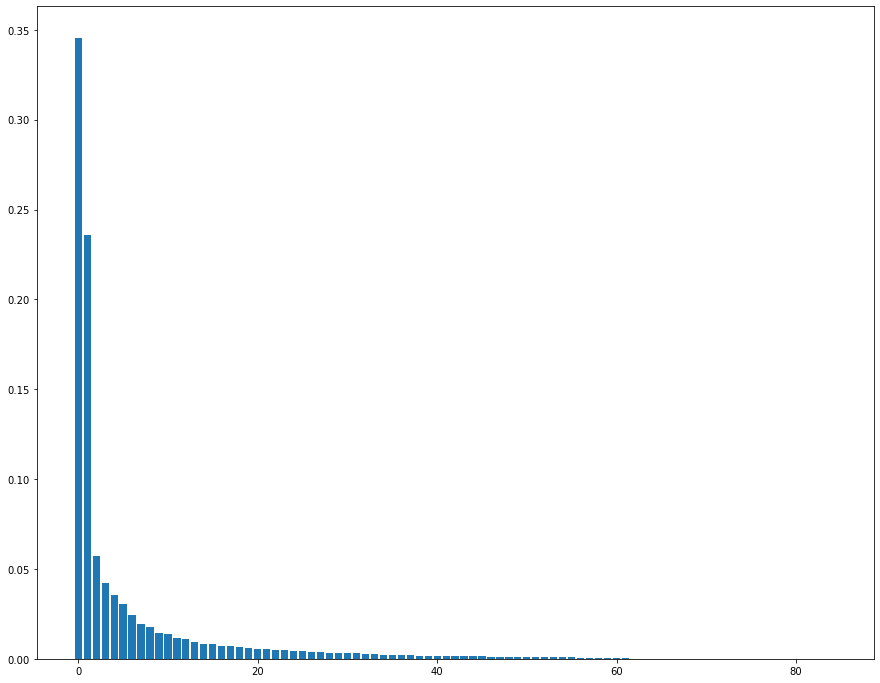

In [10]:
# Plot the explained variance ratio of each component to determine the optimal number of components

plt.figure(figsize = (15,12))
plt.bar(x = [i for i in range(components)],
       height = pca.explained_variance_ratio_)

plt.show()

In [11]:
# Implement a PCA and SelectKBest

feature_union = FeatureUnion([('pca', PCA()),
                             ('kbest', SelectKBest())])

#### Modelling Pipeline

In [12]:
# Instantiate a pipeline with random forest model 

pipeline = Pipeline([('engineering', engineering),
                    ('preprocessing', preprocessing),
                     ('features', feature_union),
                    ('model', RandomForestClassifier())])

In [13]:
# Set the parameters to be used with grid search

params = {'features__pca__n_components': [12],
          'features__kbest__k': [5, 10, 15],
        'model__n_estimators': [75, 150],
         'model__max_depth': [5, 7]}


grid_search = GridSearchCV(pipeline,
                          param_grid = params,
                          cv = 10,
                          verbose = 3)

In [14]:
X_train.shape

(9760, 69)

In [15]:
# Fit the grid search

grid_search.fit(X_train, y_train)

Fitting 10 folds for each of 12 candidates, totalling 120 fits
[CV 1/10] END features__kbest__k=5, features__pca__n_components=12, model__max_depth=5, model__n_estimators=75;, score=0.716 total time=   2.4s
[CV 2/10] END features__kbest__k=5, features__pca__n_components=12, model__max_depth=5, model__n_estimators=75;, score=0.721 total time=   2.4s
[CV 3/10] END features__kbest__k=5, features__pca__n_components=12, model__max_depth=5, model__n_estimators=75;, score=0.694 total time=   2.4s
[CV 4/10] END features__kbest__k=5, features__pca__n_components=12, model__max_depth=5, model__n_estimators=75;, score=0.718 total time=   2.5s
[CV 5/10] END features__kbest__k=5, features__pca__n_components=12, model__max_depth=5, model__n_estimators=75;, score=0.703 total time=   2.5s
[CV 6/10] END features__kbest__k=5, features__pca__n_components=12, model__max_depth=5, model__n_estimators=75;, score=0.731 total time=   2.4s
[CV 7/10] END features__kbest__k=5, features__pca__n_components=12, model

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('engineering',
                                        Pipeline(steps=[('amino',
                                                         FunctionTransformer(func=<function get_AA at 0x7fb74fc3e560>))])),
                                       ('preprocessing',
                                        ColumnTransformer(transformers=[('cat',
                                                                         Pipeline(steps=[('ohc',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['DNAtype']),
                                                                        ('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          RobustScale

In [16]:
grid_search.best_score_

0.7820696721311474

In [17]:
# Import the test dataset

test = pd.read_csv('Data/test.csv',
                   low_memory = False)
y_test = test['Kingdom']
X_test = test.drop(columns = ['Kingdom'],
                    axis = 1)

In [18]:
# Make predictions using the fitted model

preds = grid_search.predict(X_test)

In [19]:
# Check the metric scores

print(f'Accuracy: {accuracy_score(y_test, preds)}')
print(f'Recall: {recall_score(y_test, preds, average = "weighted")}')
print(f'Precision: {precision_score(y_test, preds, average = "weighted", zero_division = 1)}')
print(f'Confusion Matrix: \n {confusion_matrix(y_test, preds)}')

Accuracy: 0.784880147510756
Recall: 0.784880147510756
Precision: 0.812233743434307
Confusion Matrix: 
 [[  0  18   0   0   0   0   8   0   0   2   0]
 [  0 679   2   0   0   0  22   0   0  19   0]
 [  0  39 125   0   0   0  83   0   0  94   3]
 [  0   0   0 110   0   0  11   0   1  11   9]
 [  0  42   0   0   5   0   7   0   0   6   0]
 [  0   6   0   0   0   0   0   0   0   0   0]
 [  0  21   0   0   0   0 537   0   0  93   1]
 [  0   0   0   7   0   0   3   8   1  15  16]
 [  0   0   0  18   0   0   2   0  18  10   2]
 [  0  26   1   0   0   0  20   0   0 675   0]
 [  0   1   7   8   0   0  19   0   0  46 397]]
